# Autoencoder.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.callbacks import EarlyStopping

# Mount Google Drive.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Note all transformations were already done, and original images
# + their dihedral transformations are stored in the same folder
def loadPreprocessImages(pathFolder, num_images):
    images = []
    for idx in range(num_images):
        imgPath = os.path.join(pathFolder, f'{idx}.png')
        img = keras.preprocessing.image.load_img(imgPath, target_size=(224, 224))
        imgArray = keras.preprocessing.image.img_to_array(img)
        imgArray = imgArray / 255.0
        images.append(imgArray)
    return np.array(images)

def displayReconstructionV2(model, testImages, indices):
    # Select a random set of images from the test dataset
    testSamples = testImages[indices]

    # Predict the reconstruction of the test samples
    reconstructed = model.predict(testSamples)

    n = len(indices)

    # Plot the original and reconstructed images
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(testSamples[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
imageData = loadPreprocessImages('/content/gdrive/MyDrive/allGoodCellPatchesTrain')

In [ ]:
imagesTrain, imagesValidation = train_test_split(imageData, test_size=0.2)

In [ ]:
encodingDim = 256 # can be specified as needed

# This is our input image
inputImg = keras.Input(shape=(224, 224, 3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputImg) # (224, 224, 16)
x = MaxPooling2D((2, 2), padding='same')(x) # (112, 112, 16)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x) # (112, 112, 8)
x = MaxPooling2D((2, 2), padding='same')(x) # (56, 56, 8)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x) # (56, 56, 8)
encoded = MaxPooling2D((2, 2), padding='same')(x) # (28, 28, 8)

flatten = Flatten()(encoded)
latentVector = Dense(encodingDim, activation='relu')(flatten)

x = Dense(28*28*8, activation='relu')(latentVector)
x = Reshape((28, 28, 8))(x) # reshape to mirror encoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(inputImg, decoded)

In [ ]:
encoder = keras.Model(inputImg, latentVector)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
autoencoder.fit(imagesTrain, imagesTrain,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(imagesValidation, imagesValidation))

In [ ]:
# Note here we would save the model
# autoencoder.save('/content/gdrive/MyDrive/models/autoencoderCellsv7.keras')
# encoder.save('/content/gdrive/MyDrive/models/encoderCellsv7.keras')

Load saved model.

In [6]:
encoder = keras.models.load_model('/content/gdrive/MyDrive/models/encoderCellsv7.keras')

In [8]:
originalImages = loadPreprocessImages("/content/gdrive/MyDrive/allGoodCellPatchesWithNoBackgroundInfo", 1560)

In [9]:
encodedImgs = encoder.predict(originalImages)

49/49 [==============================] - 19s 372ms/step


In [10]:
encodedImgs.shape

(1560, 256)

In [11]:
# Perform PCA on the features
pca = PCA()
principalComponents = pca.fit(encodedImgs)

# Calculate cumulative explained variance
cumulativeExplainedVariance = pca.explained_variance_ratio_.cumsum()

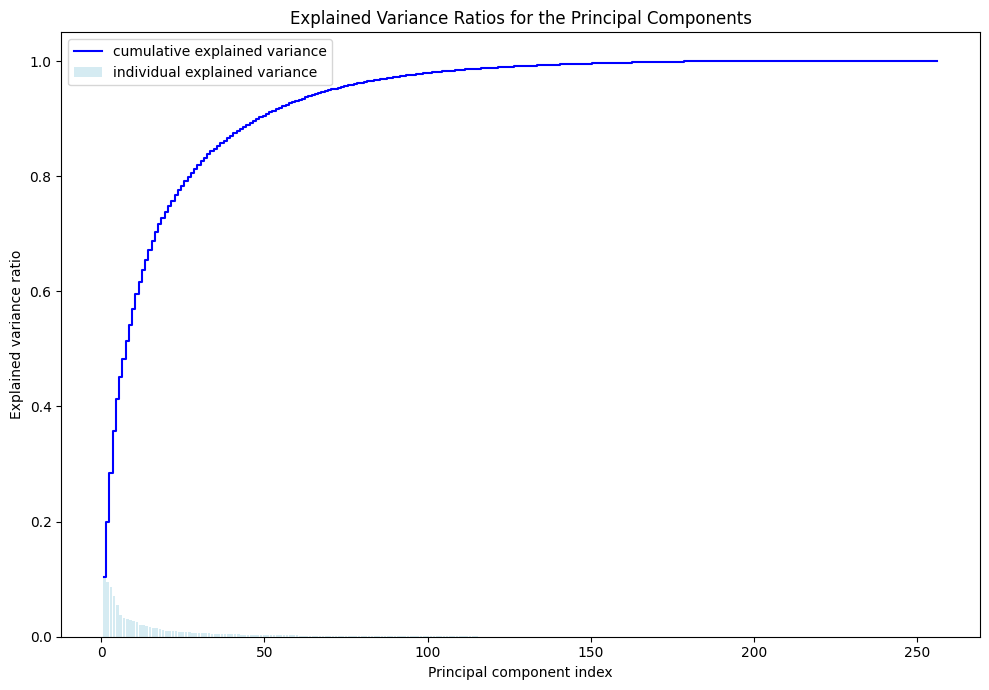

In [12]:
# Number of components to display
numComponents = len(pca.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(10, 7))
plt.bar(range(1, numComponents + 1), pca.explained_variance_ratio_[:numComponents], alpha=0.5, align='center',
        label='individual explained variance', color='lightblue')
plt.step(range(1, numComponents + 1), cumulativeExplainedVariance[:numComponents], where='mid',
         label='cumulative explained variance', color='blue')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance Ratios for the Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [13]:
# Find the number of components that explain at least 80% of the variance
n_components = np.where(cumulativeExplainedVariance >= 0.8)[0][0] + 1

In [14]:
n_components

28

In [15]:
# Initialize PCA with the number of components determined
pca_reduced = PCA(n_components=n_components)
principalComponents_reduced = pca_reduced.fit_transform(encodedImgs)

Need to find optimal number of clusters. We use the elbow method as well as silhoutte.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

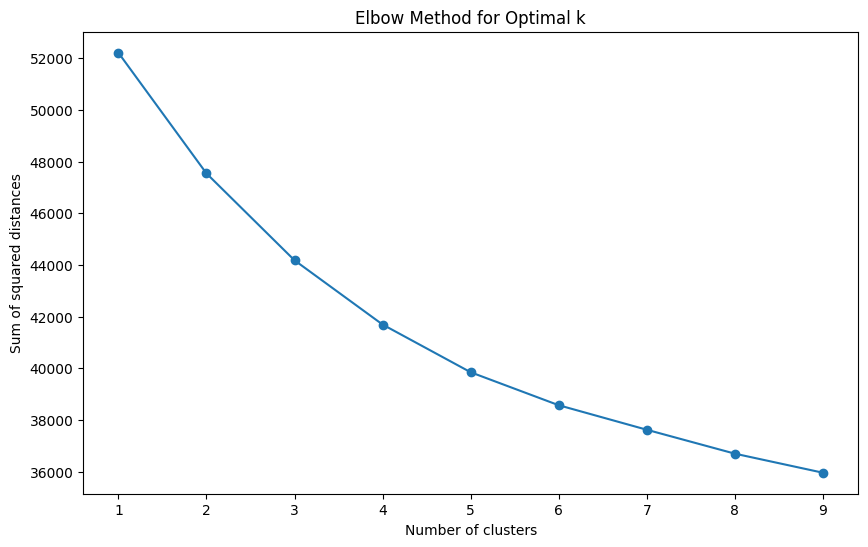

In [17]:
# Determine the range of clusters to try
k_range = range(1, 10)
sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principalComponents_reduced)
    sse.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

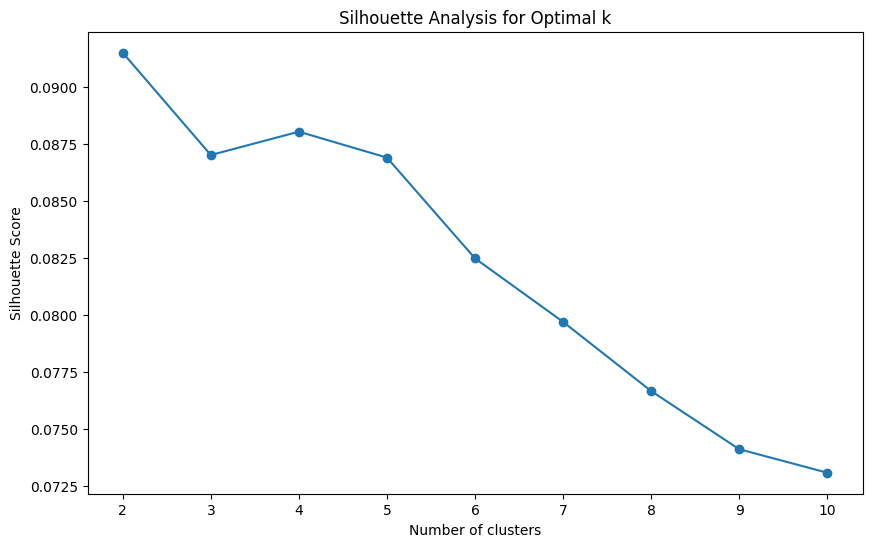

In [18]:
k_range = range(2, 11)  # Start from 2 as silhouette score cannot be calculated for k=1
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(principalComponents_reduced)
    score = silhouette_score(principalComponents_reduced, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

In [19]:
k_optimal = k_range[np.argmax(silhouette_scores)]
# Apply K-Means clustering with the optimal number of clusters
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans_final.fit_predict(principalComponents_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
def sample_images_from_clusters(cluster_labels, num_samples_per_cluster, path):
    cluster_dict = {}
    # Create a dictionary to hold indices for each cluster
    for index, label in enumerate(cluster_labels):
        if label not in cluster_dict:
            cluster_dict[label] = []
        cluster_dict[label].append(index)

    # Sample images from each cluster
    sampled_indices = {cluster: np.random.choice(indices, num_samples_per_cluster, replace=False)
                       for cluster, indices in cluster_dict.items() if len(indices) >= num_samples_per_cluster}

    # Load and plot the sampled images
    for cluster, indices in sampled_indices.items():
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            img_path = os.path.join(path, f"{idx}.png")
            img = Image.open(img_path)
            plt.subplot(1, num_samples_per_cluster, i + 1)
            plt.imshow(img)
            plt.title(f"Cluster {cluster} Image {idx}")
            plt.axis('off')
        plt.show()

def sample_images_from_clustersv2(cluster_labels, num_samples_per_cluster, path):
    cluster_dict = {}
    # Create a dictionary to hold indices for each cluster
    for index, label in enumerate(cluster_labels):
        if label not in cluster_dict:
            cluster_dict[label] = []
        cluster_dict[label].append(index)

    # Sample images from each cluster
    sampled_indices = {cluster: np.random.choice(indices, num_samples_per_cluster, replace=False)
                       for cluster, indices in cluster_dict.items() if len(indices) >= num_samples_per_cluster}

    # Load and plot the sampled images
    for cluster, indices in sampled_indices.items():
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            img_path = os.path.join(path, f"{idx}.png")
            img = Image.open(img_path)
            plt.subplot(1, num_samples_per_cluster, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

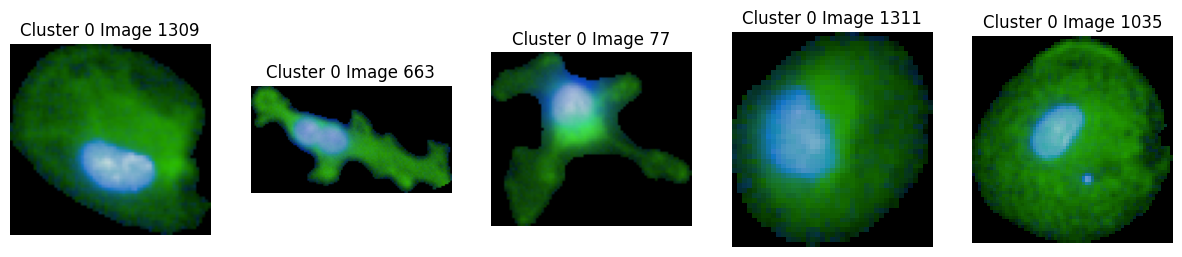

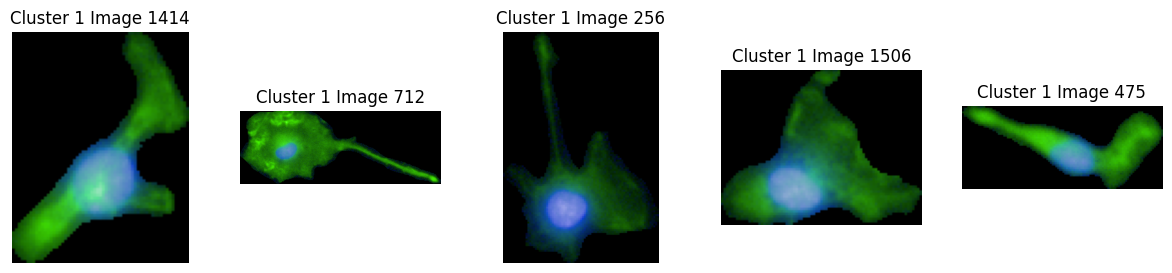

In [24]:
sample_images_from_clusters(cluster_labels, num_samples_per_cluster=5, path="/content/gdrive/MyDrive/allGoodCellPatchesWithNoBackgroundInfo")